# Projet de système de recommandation
Module Data Mining - CPE Lyon 2023

*Auteurs : Hugo MARTA et Léo GONNET (4ETI)*

---


In [8]:
# Importation des bibliothèques
import os
import sys
import numpy as np
import math
import pandas as pd
import json
import requests # requêtes http
import urllib.request # téléchargement d'images
import shutil # recursive rem
from time import sleep
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import datetime as dt

## **1.** Collecte de données

On va récupérer les images sur Wikimedia Commons à l'aide de son API.
On utilise la bibliothèque requests pour faire les requêtes HTTP.

⚠️ À chaque execution on écrase le dossier d'image !

In [10]:
# Nombre d'images à télécharger
NB_IMG_NECE = 200
NB_IMG_DL = 0

# Construire la requête à l'API de Wikimedia Commons
query = ["Car"]

# Paramétrage du header selon la User-Agent policy de Wikimedia Commons https://meta.wikimedia.org/wiki/User-Agent_policy
# permet d'augmenter le taux de requêtes
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'GogoBot/1.0 (https://cpe.fr; leo.gonnet@cpe.fr)')]
urllib.request.install_opener(opener)

# Suppression et création du dossier images
if os.path.exists("images"):
  shutil.rmtree('images')
os.makedirs("images")

# URL de l'API de recherche de médias de Wikimedia Commons
url_api = []
# Liste de json contenant les informations des images
images_json =[]
for index,keyword in enumerate(query) :
  url_api.append((keyword,f"https://commons.wikimedia.org/w/api.php?action=query&generator=images&prop=imageinfo&gimlimit=500&redirects=1&titles={keyword}&format=json&iiprop=timestamp|user|userid|comment|canonicaltitle|url|size|dimensions|sha1|mime|thumbmime|mediatype|bitdepth"))

  # Envoyer la requête et obtenir la réponse
  response = requests.get(url_api[index][1])

  # Traiter la réponse
  data = json.loads(response.text)
  results = data["query"]["pages"]

  # Nombre de résultats
  nb_res = len(results)
  ##print(f"{nb_res} résultats")

  # Extraire les URL des images et les télécharger
  print(f'Téléchargement des images de la recherche : {keyword}')
  pages = list(results.items())

  i = 3

  while NB_IMG_DL<NB_IMG_NECE and i < nb_res:
    page = pages[i]
    i += 1
    image = page[1]["imageinfo"][0]
    
    if image["mime"] == "image/jpeg": #test si l'image correspond aux critères voulus
      url_image = image["url"]
      image_file = f'images/{image["sha1"]}'
      ##sleep(1) # Eviter le  spam
      urllib.request.urlretrieve(url_image, image_file)
      images_json.append(image)

      NB_IMG_DL += 1
      print ("Images téléchargées : " + f"{NB_IMG_DL} sur {NB_IMG_NECE}", end="\r")

if NB_IMG_DL<NB_IMG_NECE:
  print(f'Pas assez d\'images utiles pour le nombre demandé ({NB_IMG_DL} images téléchargées).')
else:
  print(f'{NB_IMG_DL} images ont bien été téléchargées')

Téléchargement des images de la recherche : Car
Pas assez d'images utiles pour le nombre demandé (178 images téléchargées).


## **2.** Étiquetage et annotation

In [ ]:
# 
df = pd.json_normalize(array)
df

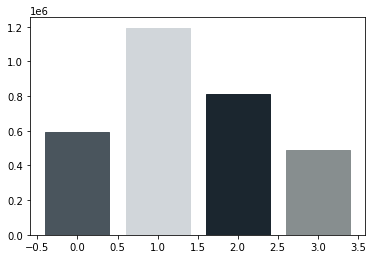

In [ ]:
imgfile = Image.open("images/01fab91f46b38d007434d7f8cd5995607754a59d")
numarray = np.array(imgfile.getdata(), np.uint8)
clusters = KMeans(n_clusters=4)
clusters.fit(numarray)
npbins = np.arange(0, 5)
histogram = np.histogram(clusters.labels_, bins=npbins)
labels = np.unique(clusters.labels_)
barlist = plt.bar(labels, histogram[0])
for i in range(4):
    barlist[i].set_color(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        )
    )
plt.show()


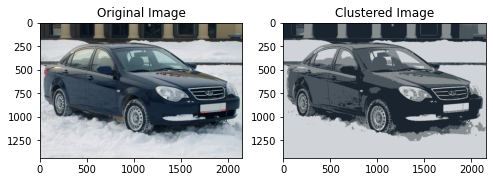

In [ ]:
def get_dominant_color(image):
    pixels = np.float32(image).reshape(-1, 3)
    n_colors = 4
    clusters = KMeans(n_clusters=n_colors, random_state=0)
    clusters.fit(pixels)
    palette = np.uint8(kmeans.cluster_centers_)
    labels = kmeans.predict(pixels)
    counts = np.bincount(labels)
    dominant_color = palette[np.argmax(counts)]
    clustered_image = np.reshape(palette[labels], (image.shape))
    return dominant_color, clustered_image

image = plt.imread("images/01fab91f46b38d007434d7f8cd5995607754a59d")

dominant_color, clustered_image = get_dominant_color(image)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(clustered_image)
plt.title("Clustered Image")

plt.show()

## **3.** Analyses de données


In [ ]:
#Liste contenant l'année de chaque image
annees=[]
for image in images_json:
  #On convertit la chaine de caractère en objet datetime
  date_string=image["timestamp"]
  date_object=dt.datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%SZ')

  annees.append(date_object.year)

#On compte le nombre de répétitions de chaque année
nbr_images_annee = [(i,annees.count(i)) for i in range(min(annees),max(annees)+1)]
print(f'Nombre d\'images disponibles par année :{nbr_images_annee}')



Nombre d'images disponibles par année :[(2005, 1), (2006, 4), (2007, 7), (2008, 13), (2009, 8), (2010, 8), (2011, 9), (2012, 2), (2013, 6), (2014, 3), (2015, 4), (2016, 8), (2017, 3), (2018, 7), (2019, 12), (2020, 17), (2021, 68), (2022, 20)]


## **4.** Visualisation des données